In [1]:
from common_functions import *

2022-12-07 18:14:49.717728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 18:14:50.465527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-07 18:14:50.465579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-07 18:14:50.465586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def codec_gif(rgb):
    return tf.io.decode_gif(tfio.image.encode_gif(np.expand_dims(rgb,0)))

def codec_jpeg(rgb,quality):
    return tf.io.decode_jpeg(tf.io.encode_jpeg(rgb,quality=quality))

def ssim_m(img1,img2):
    return tf.image.ssim_multiscale(img1,img2,255)

In [3]:
from IPython.display import clear_output

In [4]:
import glob
image_filename_list = glob.glob("imagenet_crops/*.png")
model = load_model();
perturbation_bits = [0,1,2,3,4,5,6,7,8,9]
codecs = [lambda img : img,
          lambda img : codec_gif(img),
          lambda img : codec_jpeg(img,100),
          lambda img : codec_jpeg(img,75),
          lambda img : codec_jpeg(img,50),
          lambda img : codec_jpeg(img,25),
          lambda img : codec_jpeg(img,10),
          lambda img : codec_jpeg(img,5),
          lambda img : codec_jpeg(img,0)]
accuracy = np.zeros((len(image_filename_list),
                     len(perturbation_bits),
                     len(codecs),
                    ))
quality = np.zeros((len(image_filename_list),
                     len(perturbation_bits),
                     len(codecs),
                    ))
for (i_img,image_filename) in enumerate(image_filename_list):
    rgb = png_to_rgb(image_filename)
    input_label, gradient = fgsm(model,rgb)
    for (i_bit, bit) in enumerate(perturbation_bits):
        if (bit == 0):
            attacked_img = rgb
        else:
            attacked_img = sg_attack(rgb,tf.sign(gradient),bit)
        for (i_codec,codec) in enumerate(codecs):
            test_img = np.squeeze(codec(attacked_img))
            test_label, _ = fgsm(model,test_img)
            
            quality[i_img,i_bit,i_codec] = ssim_m(rgb,test_img)
            if input_label[2] == test_label[2]:
                accuracy[i_img,i_bit,i_codec] = test_label[2]
            else:
                accuracy[i_img,i_bit,i_codec] = -test_label[2]
    clear_output()
np.save('accuracy',accuracy)
np.save('quality',quality);

In [7]:
import matplotlib.pyplot as plt

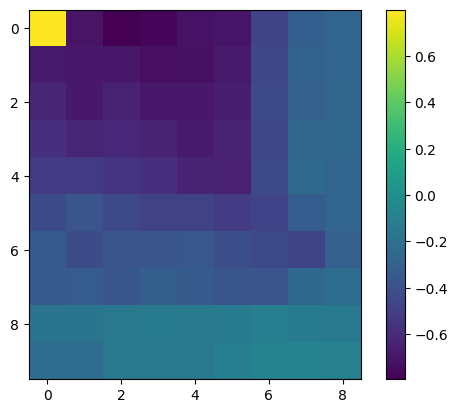

In [13]:
plt.imshow(np.mean(accuracy,axis=0))
plt.colorbar()

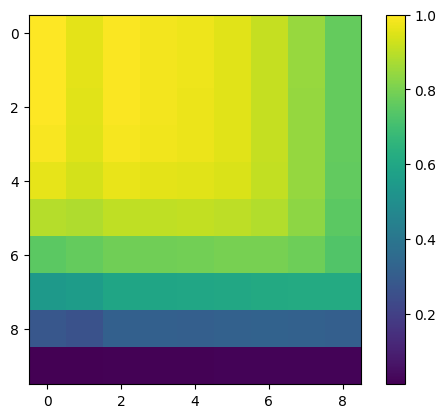

In [12]:
plt.imshow(np.mean(quality,axis=0))
plt.colorbar()